In [1]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [2]:
from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
# These models are present in unslot module in 4-bit quantised form,
# so if model weights are 32bit -> we are able to use 90 % less memory as compared to others.
# if you dont use this, you wont be able to run in google collab.
# 4-bit quantization is generally a model compression technique which reduces the precision of these model weights from 32 bits to 4 bits.
# stardard one needs 16 gb whereas, fourbit model needs 3.5 gb (4 times memory reduction)

fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [4]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.10.1: Fast Qwen2_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


In [5]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth: Making `model.base_model.model.model.visual` require gradients


In [6]:
from datasets import load_dataset
dataset = load_dataset("unsloth/Latex_OCR", split="train")

In [7]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [8]:
#REPLACE // -> / for the latext text to run in the latex compiler
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

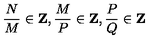

In [9]:
#Normal OCR wont let you extract anything from the image.
dataset[0]["image"]

In [10]:
dataset[2]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x50>,
 'text': 'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'}

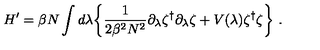

In [11]:
dataset[2]["image"]

In [12]:
# Direct Copy and Compile
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [13]:
instruction = "Write the LaTex representation for this image."

def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]
       }
  ]
  return {"messages": conversation}

In [14]:
convert_to_conversation(dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [15]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
converted_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'}]}]}

In [16]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [17]:
image = dataset[3]["image"]
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]
    }
]

In [18]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

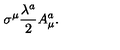

In [19]:
#image
dataset[3]["image"]

In [20]:
#actual output
dataset[3]["text"]

'\\sigma ^ { \\mu } \\frac { \\lambda ^ { a } } { 2 } A _ { \\mu } ^ { a } .'

In [21]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens = 128, use_cache=True, temperature=1.5, min_p=0.1)

The LaTeX representation for the image is:

\[
\sigma^{\mu} \lambda^{\alpha} \frac{\lambda^{\alpha}}{2 \mu^{\mu}}
\]<|im_end|>


In [22]:
# Fine Tuning using unslot
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [23]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [24]:
trainer = SFTTrainer(
    model = model,
    tokenizer=tokenizer,
    #function of data collator is to ensure that the batches are of uniform length for image and text
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps = 10,
        max_steps=50,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir="outputs",
        report_to = "none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [25]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.184700
2,1.332600
3,1.440700
4,1.052700
5,1.047100
6,1.139900
7,0.992600
8,0.714800
9,0.504700
10,0.536600


TrainOutput(global_step=50, training_loss=0.3246185152232647, metrics={'train_runtime': 335.0653, 'train_samples_per_second': 1.194, 'train_steps_per_second': 0.149, 'total_flos': 2721858506158080.0, 'train_loss': 0.3246185152232647, 'epoch': 0.005823603063215211})

In [26]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [27]:
image = dataset[3]["image"]
instruction = "Write the LaTeX representation for this image."
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

In [28]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

\sigma ^ { \mu } \frac { \lambda ^ { a } } { 2 } A ^ { \mu } ^ { a } .<|im_end|>


In [29]:
# Install the required library for edit distance calculation
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.5 MB/s eta 0:00:00


In [30]:
import torch
from Levenshtein import distance as levenshtein_distance
from tqdm import tqdm
from datasets import load_dataset
# Assume FastVisionModel, tokenizer, and model are already defined and loaded

# --- 3. Load the Evaluation Dataset (First 100 Samples of Test Split) ---
eval_dataset = load_dataset("unsloth/Latex_OCR", split="test[:100]") # Evaluates on 100 samples

# --- 4. Define the Evaluation Metric Function (NED) ---
def calculate_ned(predicted: str, reference: str) -> float:
    """Calculates Normalized Edit Distance (NED) based on Levenshtein distance."""
    # Clean up whitespace and special characters
    predicted = predicted.strip()
    reference = reference.strip()

    lev_distance = levenshtein_distance(predicted, reference)
    max_len = max(len(predicted), len(reference))

    # Handle empty strings case
    if max_len == 0:
        return 0.0

    return lev_distance / max_len

# --- 5. Run Inference on the Evaluation Set ---
FastVisionModel.for_inference(model) # Ensure model is in inference mode
model.eval()

all_neds = []
instruction = "Write the LaTeX representation for this image."

# Loop through the 100 samples in the evaluation dataset
for sample in tqdm(eval_dataset, desc="Evaluating Model on 100 Samples"):
    image = sample["image"]
    reference_latex = sample["text"]

    # Format the multi-modal chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    # Tokenize the input and move to GPU
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # Generate the output (using low temperature for deterministic evaluation)
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=0.1,
            min_p=0.1,
            do_sample=True,
        )

    # Decode and extract the predicted LaTeX
    predicted_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Robustly extract the assistant's final response (the LaTeX code)
    try:
        assistant_prefix = 'assistant\n'
        predicted_latex = predicted_text.split(assistant_prefix)[-1].strip()
        if tokenizer.eos_token in predicted_latex:
            predicted_latex = predicted_latex.split(tokenizer.eos_token)[0].strip()
    except Exception:
        predicted_latex = predicted_text.strip()

    # Calculate NED for the sample
    ned_score = calculate_ned(predicted_latex, reference_latex)
    all_neds.append(ned_score)

# --- 6. Final Results Calculation and Output ---
if all_neds:
    average_ned = sum(all_neds) / len(all_neds)
    average_accuracy = 1.0 - average_ned

    print("\n" + "=" * 50)
    print("       FINAL EVALUATION METRICS (100 Samples)")
    print("=" * 50)
    print(f"Total Samples Evaluated: {len(eval_dataset)}")
    print(f"Average Normalized Edit Distance (NED): {average_ned:.4f}")
    print(f"Average Character Accuracy (1 - NED): {average_accuracy * 100:.2f}%")
    print("=" * 50)
    print("Interpretation: NED is the character-level error rate. Lower is better.")
else:
    print("\nNo samples were evaluated. Please check the dataset loading.")

Evaluating Model on 100 Samples: 100%|██████████| 100/100 [15:28<00:00,  9.29s/it]


       FINAL EVALUATION METRICS (100 Samples)
Total Samples Evaluated: 100
Average Normalized Edit Distance (NED): 0.2067
Average Character Accuracy (1 - NED): 79.33%
Interpretation: NED is the character-level error rate. Lower is better.
